In [1]:
#!pip install -q --upgrade pandas
import pandas as pd

#projects1_1 = pd.read_csv('kickstarter-projects/ks-projects-201612.csv', encoding='latin1')
projects1 = pd.read_csv('kickstarter-projects/ks-projects-201801.csv')
projects2 = pd.read_csv('funding-successful-projects-on-kickstarter/train.csv')

In [2]:
pd.__version__

'0.22.0'

In [3]:
projects = projects1.merge(projects2, on='name', how='inner')
projects = projects.dropna()
projects.columns

Index(['ID', 'name', 'category', 'main_category', 'currency_x', 'deadline_x',
       'goal_x', 'launched', 'pledged', 'state', 'backers', 'country_x',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'project_id',
       'desc', 'goal_y', 'keywords', 'disable_communication', 'country_y',
       'currency_y', 'deadline_y', 'state_changed_at', 'created_at',
       'launched_at', 'backers_count', 'final_status'],
      dtype='object')

In [4]:
import numpy as np

renames = {
    'country_x': 'country',
    'currency_x': 'currency',
    'usd_goal_real': 'goal',
    'usd_pledged_real': 'pledged',
    'country_y': 'country',
    'currency_y': 'currency',
    'deadline_y': 'deadline',
    'backers_count': 'backers'
}

to_num = lambda x: pd.to_numeric(x, errors='coerce')
to_date = lambda x: pd.to_datetime(x, unit='s')
conversions = {
    'backers': to_num,
    'deadline': to_date,
    'launched_at': to_date,
    'state_changed_at': to_date,
    'created_at': to_date,
    'goal': to_num,
    'pledged': to_num,
}

drops = (
    'ID', 'project_id', 'keywords', 'deadline_x', 
    'disable_communication', 
    'goal_x', 'goal_y', 'usd pledged'
)

In [5]:
def clean_df(df, renames=None, retypes=None, drops=None):
    if renames is not None:
        for orig, new in renames.items():
            if new in df.columns:
                diffs = df[[orig, new]][df[orig] != df[new]]
                print("The following columns showed differences when renaming!")
                print(diffs[:10])
                df[new] = df[orig]
                df = df.drop(orig, axis=1)
            else:
                df = df.rename(columns={orig: new})
    if retypes is not None:
        for col, conv in retypes.items():
            dfcol = df[col]
            df = df.drop(col, axis=1)
            df[col] = conv(dfcol)
    if drops is not None:
        for col in drops:
            df = df.drop(col, axis=1)
            
    df = df.dropna(axis=1, how='all')
    df = df.dropna(axis=0, how='any')
    return df
            
cleaned = clean_df(projects, renames, conversions, drops)   

The following columns showed differences when renaming!
    usd_pledged_real  pledged
4               6.29     48.0
5           42174.03  48905.0
6              31.09     21.0
25              2.36      3.0
29           9110.34  11336.0
40           1122.89    756.0
44            485.72    293.0
47             16.58     10.0
49            628.47    656.0
57           4848.23   3097.0
The following columns showed differences when renaming!
    country_y country
109        US      GB
128        US      GB
345        US      CA
347        US      GB
398        US      GB
399        US      GB
416        CA      US
432        US      CA
863        US      AU
896        GB      US
The following columns showed differences when renaming!
    currency_y currency
109        USD      GBP
128        USD      GBP
345        USD      CAD
347        USD      GBP
398        USD      GBP
399        USD      GBP
416        CAD      USD
432        USD      CAD
863        USD      AUD
896        GBP      

In [6]:
from scipy import stats

cleaned['desc_len'] = cleaned.desc.str.len()

try:
    ######################
    ## I'm filtering out projects that lasted less than a day. 
    ## (Seems to be about 1,000 of them)
    ######################
    cleaned['duration'] = cleaned['deadline'] - cleaned['launched_at']
    real_duration = cleaned['state_changed_at'] - cleaned['launched_at']
    cleaned = cleaned[real_duration > pd.Timedelta(days=1)]
except Exception:
    print("Couldn't create duration or filter dataset")
    pass

cleaned = cleaned[cleaned['goal'] > 100]
cleaned = cleaned[cleaned['goal'] <= 2e6]
#cleaned = cleaned[cleaned['pledged'] > 100]

In [7]:
#print out statistics of our data after filtering
print("Goal\n", "min:", cleaned['goal'].min(), 
      "max:", cleaned['goal'].max(), 
      "mean:", cleaned['goal'].mean())
print("Pledged\n", "min:", cleaned['pledged'].min(), 
      "max:", cleaned['pledged'].max(), 
      "mean:", cleaned['pledged'].mean())
print("Duration\n", "min:", cleaned['duration'].min(), 
      "max:", cleaned['duration'].max(), 
      "mean:", cleaned['duration'].mean())

Goal
 min: 100.41 max: 2000000.0 mean: 20349.89003890929
Pledged
 min: 0.0 max: 20338986.27 mean: 10340.152047991494
Duration
 min: 1 days 00:00:00 max: 91 days 23:00:00 mean: 34 days 01:29:44.790419


In [8]:
pd.pivot_table(cleaned, columns=['state'])

state,canceled,failed,live,successful,suspended
backers,26.402404,19.372138,48.600,271.952603,108.502304
desc_len,120.694157,128.288668,127.400,130.270497,114.958525
final_status,0.004351,0.005938,0.200,0.720024,0.004608
goal,42133.427702,27079.853011,72006.228,9923.729924,35144.411613
pledged,2028.150404,1366.204946,177.222,21852.853984,7948.722627


In [9]:
cleaned.groupby('state').size()

state
canceled       4826
failed        51360
live              5
successful    43568
suspended       217
dtype: int64

In [10]:
succ_fail_only = cleaned[(cleaned.state == 'successful') | (cleaned.state == 'failed')]

In [11]:
import traceback

def cannot_crash(fn):
    def inner(*args, **kwargs):
        try:
            return fn(*args, **kwargs)
        except Exception:
            print(traceback.format_exc())
    return inner
            

In [12]:
import numpy as np
import matplotlib.pyplot as plt

@cannot_crash
def summarize(df):
    n_failed = np.count_nonzero(df.state == 'failed')
    print("{} Failed".format(n_failed))
    n_success = np.count_nonzero(df.state == 'successful')
    print("{} Success".format(n_success))
 
@cannot_crash
def hist_by_group(df, groupname, n_groups=None):
    if n_groups is None:
        grouped = df.groupby(groupname)
        names = grouped.groups.keys()
    else:
        pcts = np.arange(0, 1, 1/float(n_groups))
        quantiles = df[groupname].quantile(pcts)
        inds = np.digitize(df[groupname], quantiles)
        grouped = df.groupby(inds)
        names = []
        for a, b in zip(pcts, pcts[1:]):
            names.append('{}-{}'.format(quantiles[a], quantiles[b]))
        names.append('{}-{}'.format(quantiles[b], max(df[groupname])))
    
    num_groups = len(grouped)
    
    successes = []
    failures = []

    margins = []
    totals = []
    
    for name, group in grouped:

        n_failed = np.count_nonzero(group.state == 'failed')
        n_success = np.count_nonzero(group.state == 'successful')
        successes.append(float(n_success) / len(group))
        failures.append(float(n_failed) / len(group))
        
        margins.append(np.abs(n_success - n_failed))
        totals.append(n_success + n_failed)
    
    
    
    bar_width = .25
    indices = np.arange(num_groups)
    
    plt.bar(indices, successes, bar_width, color='g', label='succes')
    plt.bar(indices + bar_width, failures, bar_width, color='r', label='failures')
    plt.xticks(indices + bar_width * 1.5, names)
    plt.gca().set_ylabel("Percentage")
    plt.gca().set_xlabel(groupname)
    plt.legend()
   
@cannot_crash
def rolling_success(df):
    
    statuses = df[(df['state'] == 'failed') | (df['state'] == 'successful')]
    
    statuses['succeeded'] = statuses['state'] == 'successful'
    
    grouped = statuses.groupby((statuses['goal'] / 1000).astype(int))

    not_alone = grouped.size() > 10
    
    success_rate = grouped['succeeded'].mean()[not_alone]
    
    ax = plt.subplot()
    print(success_rate.shape)
    plt.plot(success_rate.index, success_rate, '.')
    ax.set_xscale('log')
    ax.set_xlabel("Goal")
    ax.set_ylabel("Success Ratio")

@cannot_crash
def success_over_time(df, col):
    creations = df['created_at'].astype(np.int64)
    quantiles = creations.quantile(np.arange(0, 1, .1))
    inds = np.digitize(creations, quantiles)
    grouped = df.groupby(inds)
    
    unique_cols = df[col].unique()
    
    dates = []
    data = []
    names = []
    for unique_col in unique_cols:
        col_data = []
        for _, group in grouped:
            group = group[group[col] == unique_col]
            n_failed = np.count_nonzero(group.state == 'failed')
            n_success = np.count_nonzero(group.state == 'successful')
            col_data.append(n_success / len(group))
        data.append(col_data)
        names.append(unique_col)

    all_data = []
    for _, group in grouped:
        n_failed = np.count_nonzero(group.state == 'failed')
        n_success = np.count_nonzero(group.state == 'successful')
        all_data.append(n_success / len(group))

        
    for q in quantiles:
        dates.append(np.datetime64(int(q), 's'))
        
    fig, ax = plt.subplots()
    for dat in data:
        ax.plot(dates, dat)
    
    ax.plot(dates, all_data, 'k', linewidth=3)
    
    plt.legend(names + ['All'])
    plt.show()
        
    

<IPython.core.display.Javascript object>


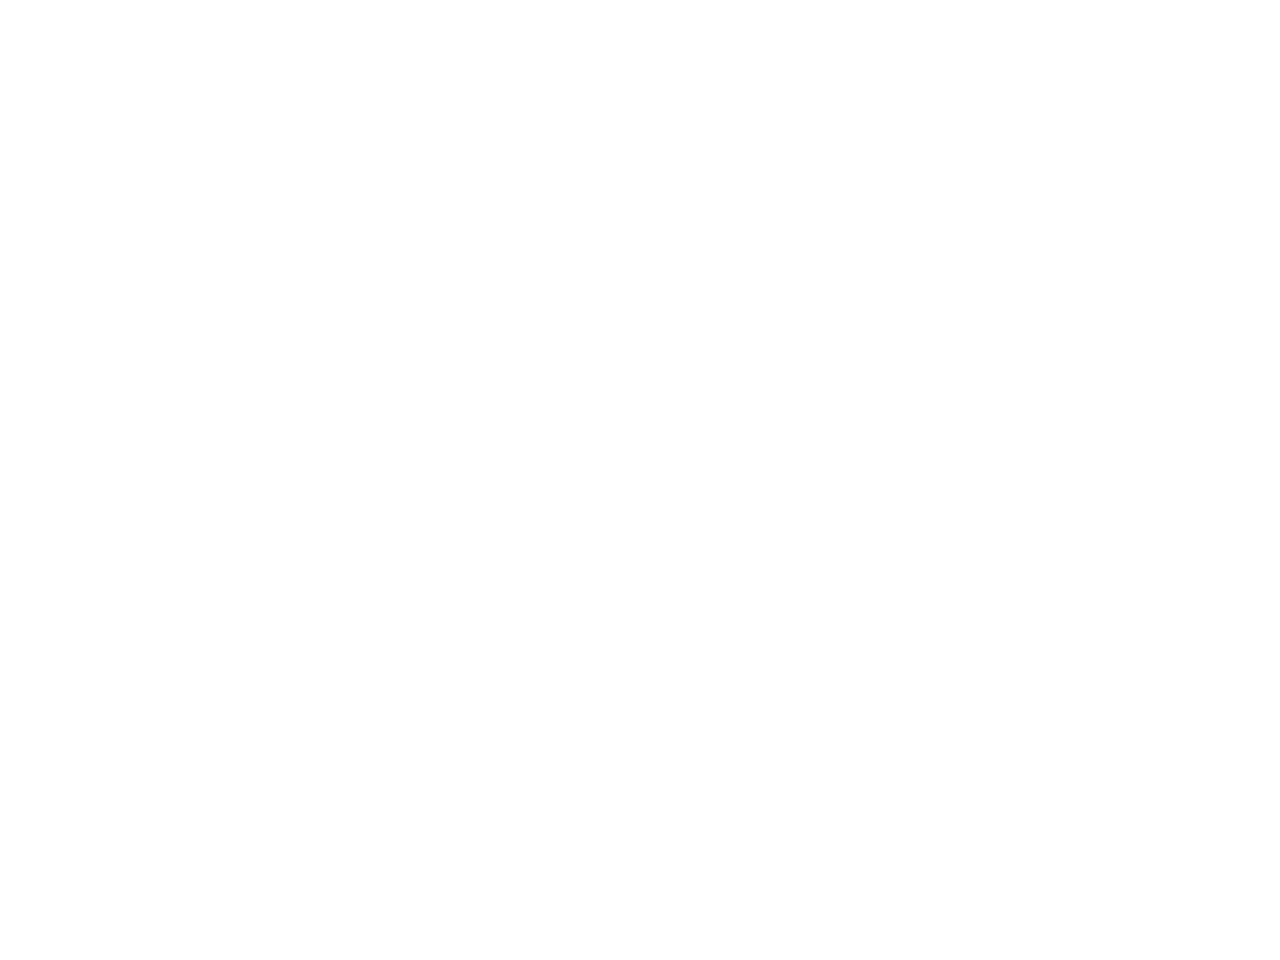

In [13]:
%matplotlib notebook

success_over_time(cleaned, 'main_category')

        

51360 Failed
43568 Success


<IPython.core.display.Javascript object>


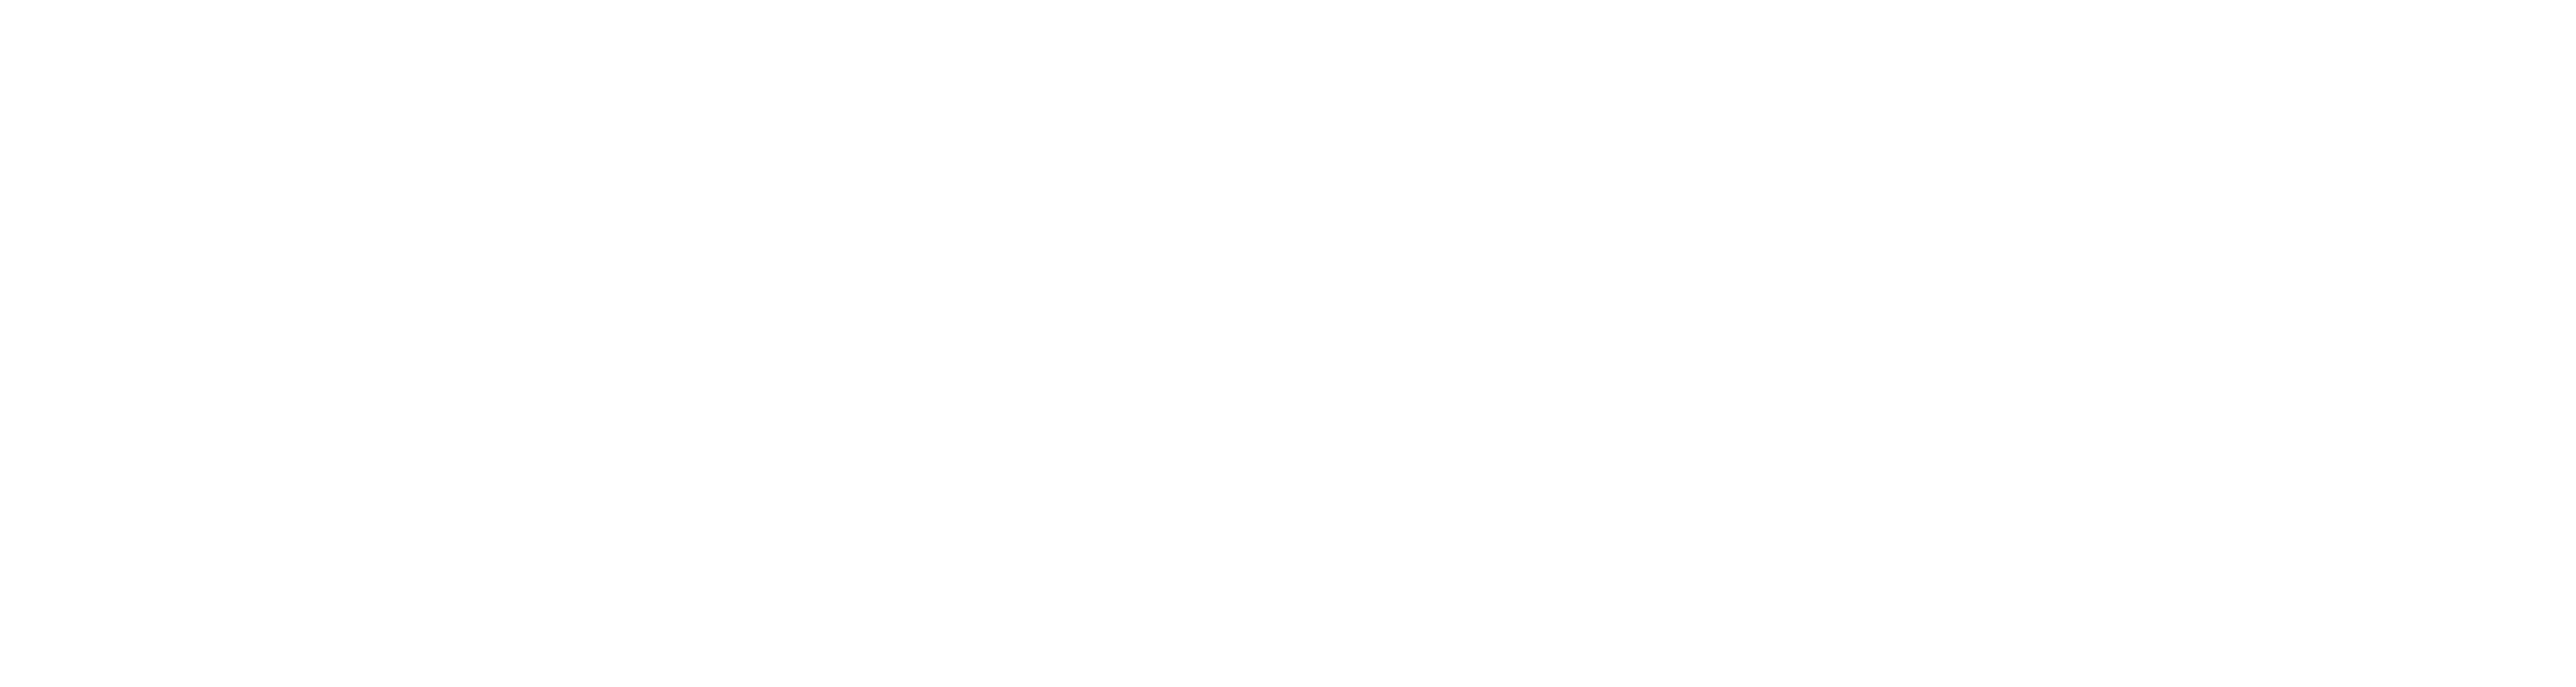

<IPython.core.display.Javascript object>


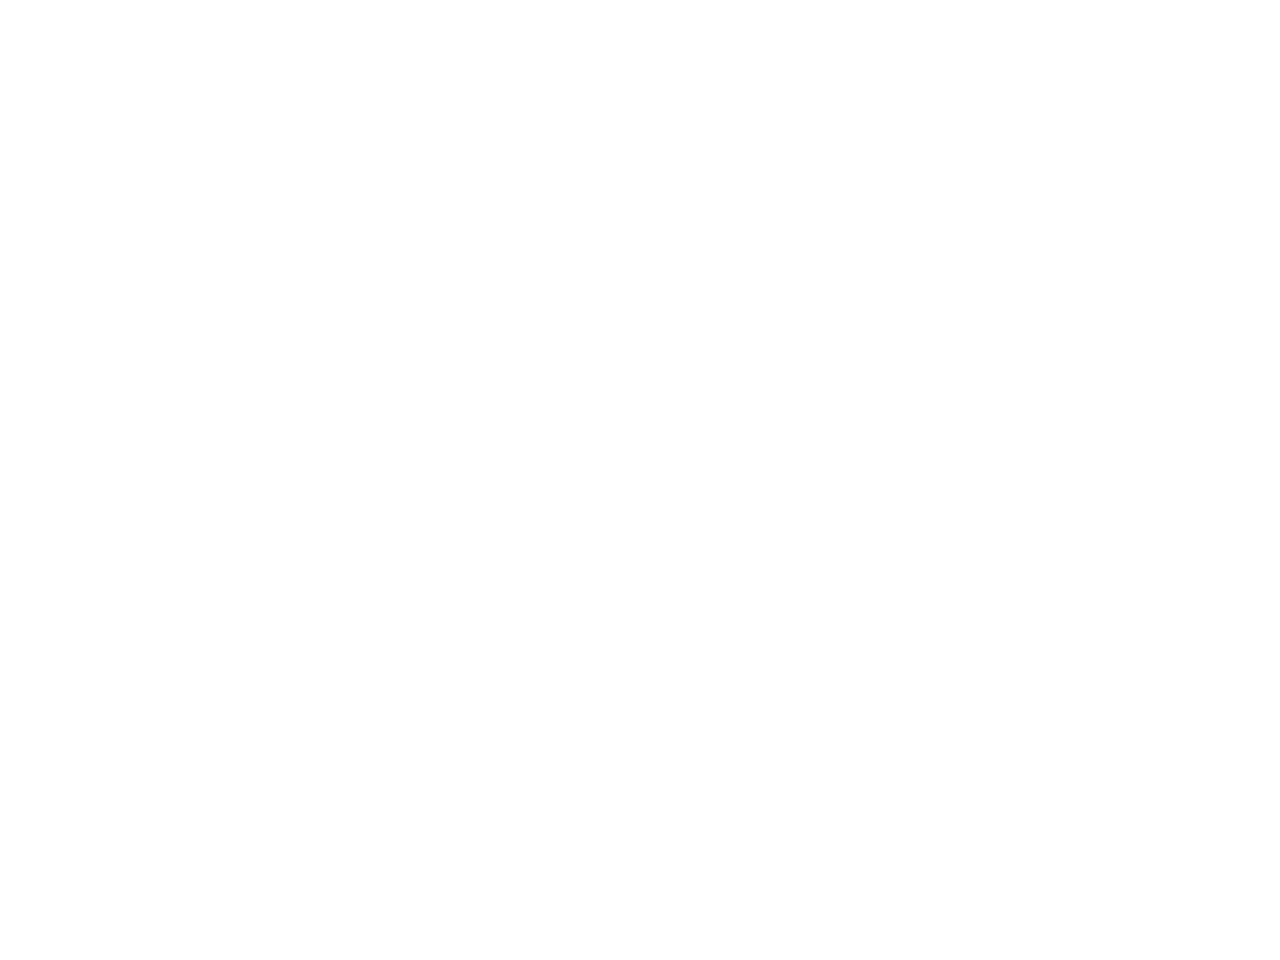

(124,)


/Users/chloele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
%matplotlib notebook

summarize(cleaned)
plt.figure(figsize=(15, 4))
hist_by_group(cleaned, 'main_category')
plt.tight_layout()

plt.figure()
rolling_success(cleaned)



<IPython.core.display.Javascript object>


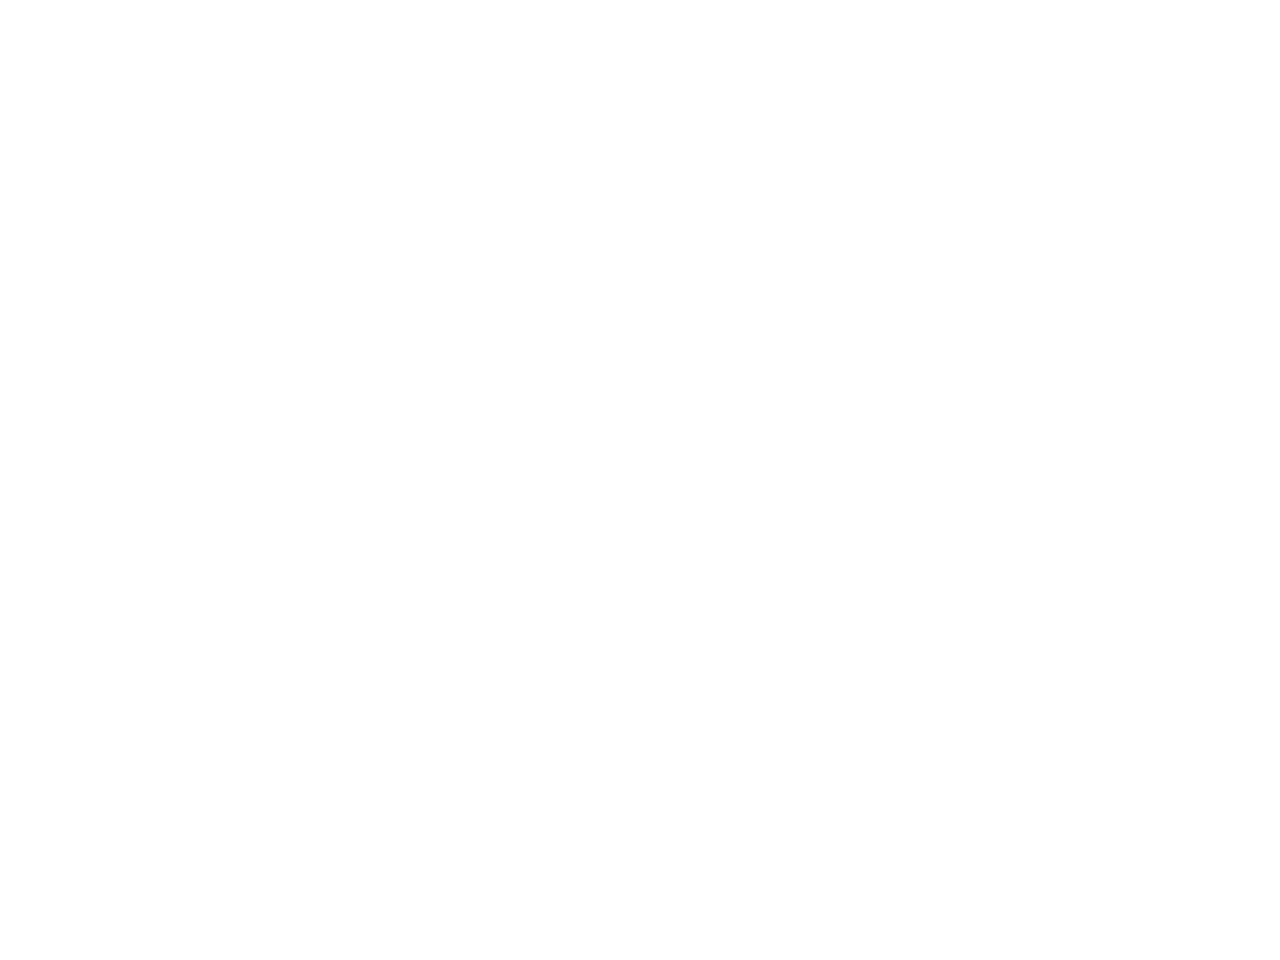

In [15]:
@cannot_crash
def show_goal_hist():
    fig, ax = plt.subplots()
    ax.hist(np.log(cleaned['goal']), 50)
    plt.show()
    plt.xlabel("log(USD Goal)")
    plt.title("Distribution of goals in US $")
    
show_goal_hist()

In [16]:
@cannot_crash
def goal_percent_comparison(successes, failures, canceled=None):
    ax = plt.subplot()
    plt.plot(successes.goal, successes.pledged/successes.goal, 'g.', alpha=.2)
    plt.plot(failures.goal, failures.pledged/failures.goal, 'r.', alpha=.2)
    if canceled is not None:
        plt.plot(canceled.goal, canceled.pledged/canceled.goal, 'y.', alpha=.2)
    ax.set_xscale('log')
    ax.set_xlabel('Goal')
    ax.set_ylabel('% Of Goal Reached')
    plt.ylim([0, 2])
    plt.legend(['successes','failures', 'canceled'])

<IPython.core.display.Javascript object>


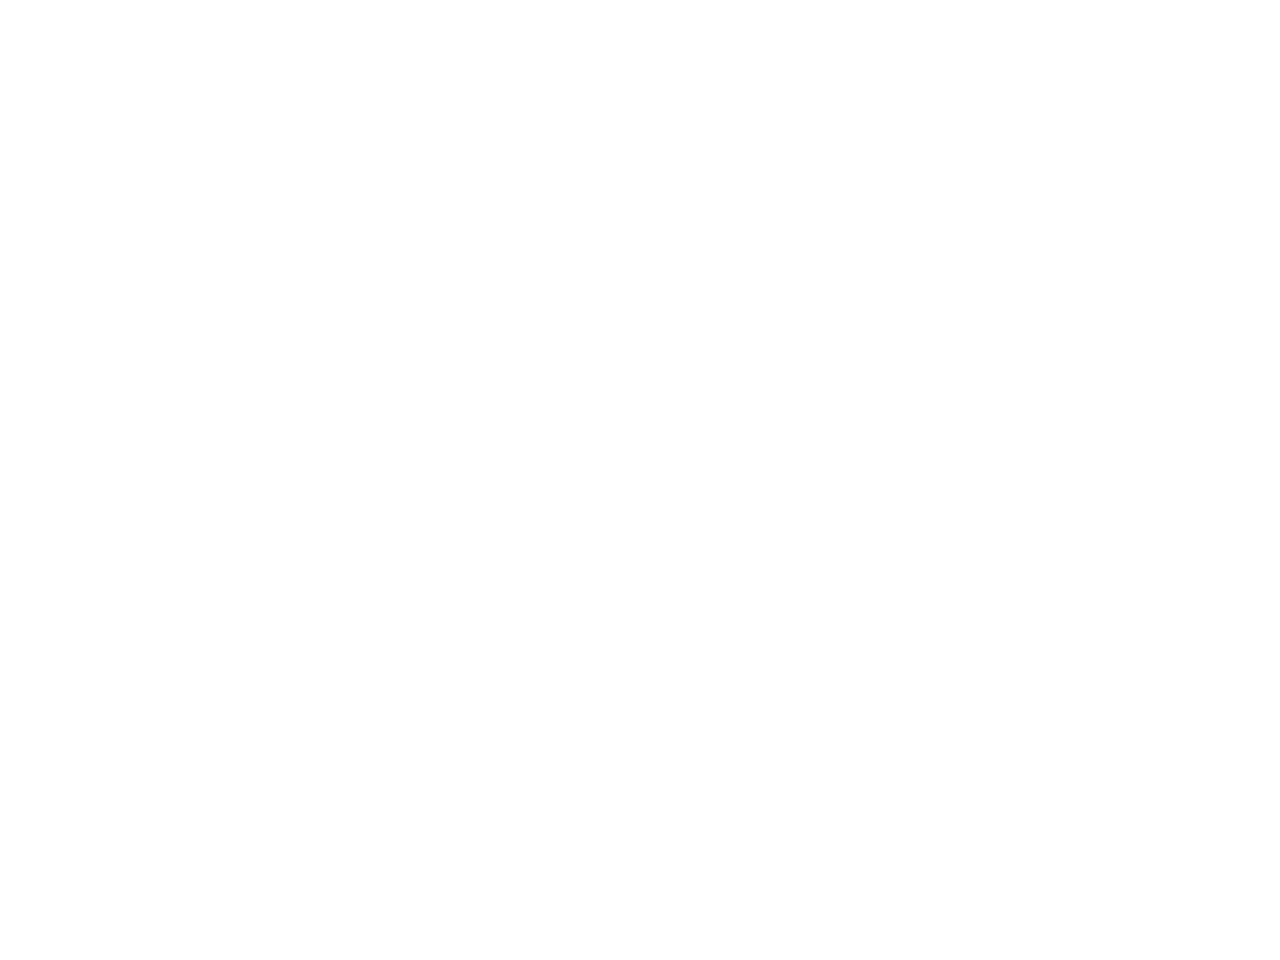

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
successes = cleaned[cleaned.state == 'successful']
failures = cleaned[cleaned.state == 'failed']
canceled = cleaned[cleaned.state == 'canceled']

goal_percent_comparison(successes,failures, canceled)


In [18]:
import re
from sklearn.feature_extraction import DictVectorizer

def create_feature_matrix(df,
                          scalars=None,
                          percentiles = None,
                          categoricals=None,
                          splits=None):
    # Should be done using apply or map or something like that
    ds = []
    Y = []
    grps = {}
    
    sorted_pcts = {}
    print("Sorting necessary columns")
    if percentiles:
        for pct in percentiles:
            sorted_pcts[pct] = np.array(sorted(df[pct]))
     
    ds = []   
    
    print("Iterating over rows ",end='', flush=True)
    for i, r in df.iterrows():
        if i % 10000 == 0:
            print('.', end='', flush=True)
        d = {}
        if percentiles is not None:
            for pct in percentiles:
                d[pct] = float(np.searchsorted(sorted_pcts[pct], r[pct])) / len(sorted_pcts[pct])
        
        if scalars is not None:
            for sca in scalars:
                try:
                    d[sca] = pd.to_numeric(r[sca])
                except:
                    print(d[sca])
                    continue
                           
        if categoricals is not None:
            for cat in categoricals:
                d[cat + r[cat]] = 1
                
        if splits is not None:
            for spl in splits:
                for word in r[spl].split():
                    d[spl+'_'+word.upper()] = 1
                
        ds.append(d)
    
    v = DictVectorizer()
    print("Vectorizing")
    X = v.fit_transform(ds)
    return X.astype(float)


In [19]:
all_features = create_feature_matrix(cleaned,
    percentiles = ('goal', 'created_at', 'desc_len', 'duration'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('desc', 'name',)
)
all_features

Sorting necessary columns
Iterating over rows ..........Vectorizing


<99976x222097 sparse matrix of type '<class 'numpy.float64'>'
	with 3051757 stored elements in Compressed Sparse Row format>

In [20]:
all_features_succ_fail_only = create_feature_matrix(succ_fail_only,
    percentiles = ('goal', 'created_at', 'desc_len', 'duration'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('desc', 'name',)
)
all_features_succ_fail_only

Sorting necessary columns
Iterating over rows .........Vectorizing


<94928x214672 sparse matrix of type '<class 'numpy.float64'>'
	with 2899255 stored elements in Compressed Sparse Row format>

In [21]:
no_desc = create_feature_matrix(cleaned,
    percentiles = ('goal', 'duration'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('name',)
)
no_desc

Sorting necessary columns
Iterating over rows ..........Vectorizing


<99976x86389 sparse matrix of type '<class 'numpy.float64'>'
	with 1043228 stored elements in Compressed Sparse Row format>

In [22]:
all_features_no_date = create_feature_matrix(cleaned,
    percentiles = ('goal', 'desc_len'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('desc', 'name',)
)
all_features_no_date

Sorting necessary columns
Iterating over rows ..........Vectorizing


<99976x222095 sparse matrix of type '<class 'numpy.float64'>'
	with 2851810 stored elements in Compressed Sparse Row format>

In [23]:
import numpy as np
import sklearn
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score

@cannot_crash
def run_classifier(X, Y, clf, n_folds=5):
    kf = KFold(n_splits=n_folds)
    
    p_corrects = []
    for train, test in kf.split(X):
        x_train = X[train]
        x_test = X[test]
        
        y_train = Y[train]
        y_test = Y[test]
        
        clf.fit(x_train, y_train)
        
        predY = clf.predict(x_test)
    
        p_corrects.append(np.count_nonzero(predY == y_test) / float(len(y_test)))
        print('\tFold accuracy: {:.3f}'.format(p_corrects[-1]))
        
    print("Mean correct across {} folds: {:.3f}".format(n_folds, np.mean(p_corrects)))
    return np.mean(p_corrects)

Y = (cleaned.state == 'successful').values
Y_succ_fail_only = (succ_fail_only.state == 'successful').values

print("Baseline accuracy is {:.3f}".format( 1 - (float(sum(Y)) / len(Y))))
print("Baseline accuracy s/f only is {:.3f}".format( 1 - (float(sum(Y_succ_fail_only)) / len(Y_succ_fail_only))))

Baseline accuracy is 0.564
Baseline accuracy s/f only is 0.541


In [24]:
def tuningSVC(features, y):
    Cs = [0.3, 0.5, 0.8, 1.0, 1.5]
    bestLoss = ''
    bestPenal = ''
    bestC = 0
    bestAccuracy = 0
    for c in Cs:
        clt = LinearSVC(C = c)
        currAccuracy = run_classifier(features, y, clt)
        print(currAccuracy)
        if currAccuracy > bestAccuracy:
            bestAccuracy = currAccuracy
            bestC = c
    print("accuracy is:", bestAccuracy)
    print("best C is:", bestC)
    
#tuningSVC(all_features, Y)
#tuningSVC(all_features_succ_fail_only, Y_succ_fail_only)
#tuningSVC(all_features_no_date, Y)
#tuningSVC(no_desc, Y)

In [25]:
run_classifier(all_features, Y, LinearSVC())

	Fold accuracy: 0.720
	Fold accuracy: 0.730
	Fold accuracy: 0.720
	Fold accuracy: 0.724
	Fold accuracy: 0.719
Mean correct across 5 folds: 0.723


0.72262345292264252

In [26]:
# Tuned Linear SVC with C = 0.3
run_classifier(all_features, Y, LinearSVC(C = 0.3))

	Fold accuracy: 0.733
	Fold accuracy: 0.740
	Fold accuracy: 0.733
	Fold accuracy: 0.736
	Fold accuracy: 0.732
Mean correct across 5 folds: 0.735


0.73487638763061436

In [27]:
run_classifier(all_features_succ_fail_only, Y_succ_fail_only, LinearSVC())

	Fold accuracy: 0.708
	Fold accuracy: 0.717
	Fold accuracy: 0.708
	Fold accuracy: 0.713
	Fold accuracy: 0.707
Mean correct across 5 folds: 0.710


0.71044368775284594

In [28]:
# Tuned Linear SVC with C = 0.3
run_classifier(all_features_succ_fail_only, Y_succ_fail_only, LinearSVC(C = 0.3))

	Fold accuracy: 0.721
	Fold accuracy: 0.728
	Fold accuracy: 0.721
	Fold accuracy: 0.728
	Fold accuracy: 0.719
Mean correct across 5 folds: 0.723


0.72322180758837007

In [29]:
run_classifier(all_features_no_date, Y, LinearSVC())

	Fold accuracy: 0.718
	Fold accuracy: 0.728
	Fold accuracy: 0.718
	Fold accuracy: 0.720
	Fold accuracy: 0.716
Mean correct across 5 folds: 0.720


0.7202528792830335

In [30]:
# Tuned Linear SVC with C = 0.3
run_classifier(all_features_no_date, Y, LinearSVC(C = 0.3))

	Fold accuracy: 0.730
	Fold accuracy: 0.739
	Fold accuracy: 0.732
	Fold accuracy: 0.733
	Fold accuracy: 0.729
Mean correct across 5 folds: 0.733


0.73262585400300861

In [31]:
run_classifier(no_desc, Y, LinearSVC())

	Fold accuracy: 0.716
	Fold accuracy: 0.725
	Fold accuracy: 0.726
	Fold accuracy: 0.719
	Fold accuracy: 0.721
Mean correct across 5 folds: 0.721


0.7213031663597036

In [32]:
# Tuned Linear SVC with C = 0.3
run_classifier(no_desc, Y, LinearSVC(C = 0.3))

	Fold accuracy: 0.729
	Fold accuracy: 0.736
	Fold accuracy: 0.738
	Fold accuracy: 0.733
	Fold accuracy: 0.733
Mean correct across 5 folds: 0.734


0.73375615358130386

<IPython.core.display.Javascript object>


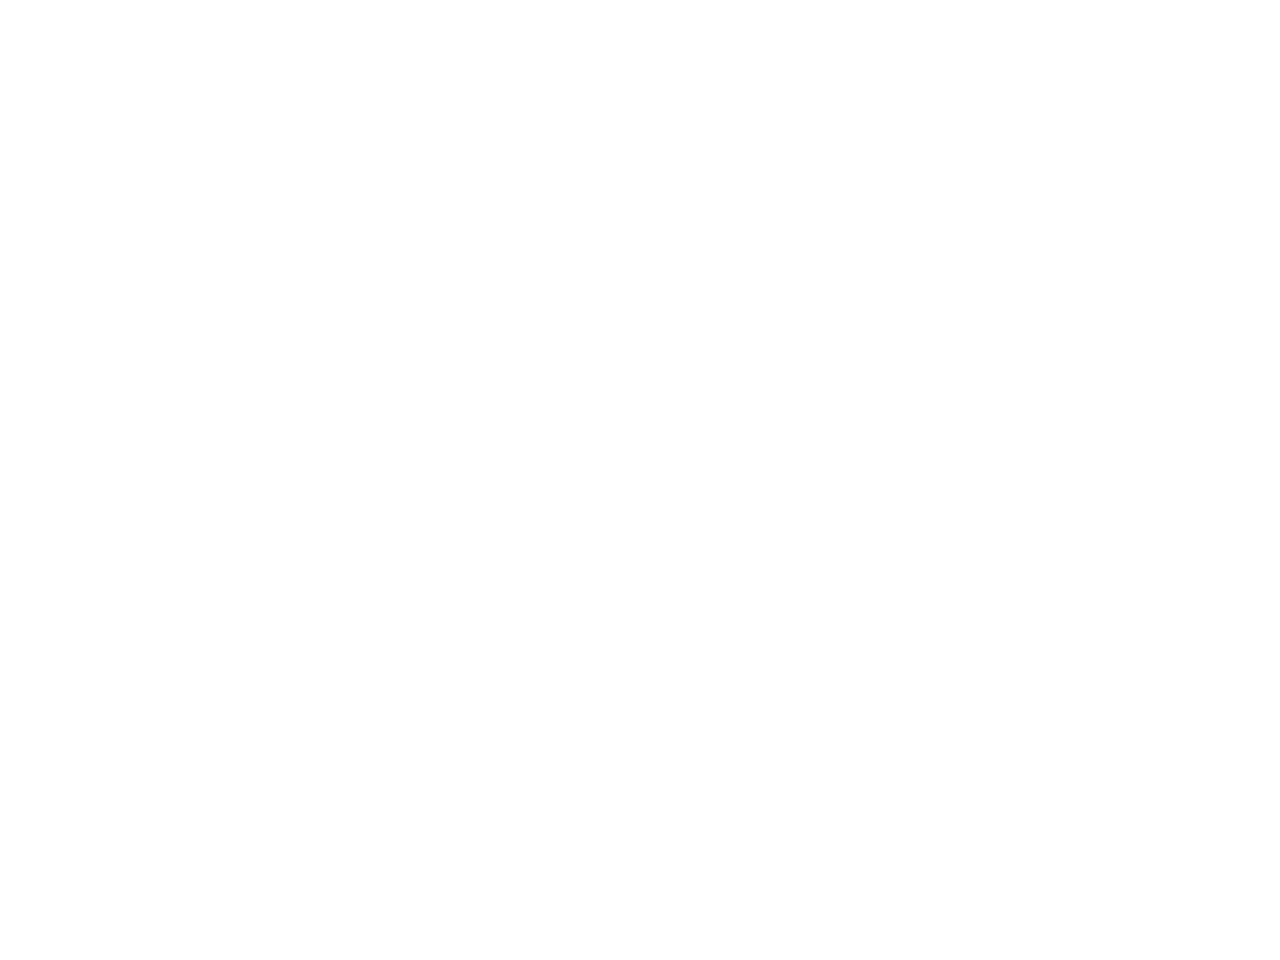

<IPython.core.display.Javascript object>


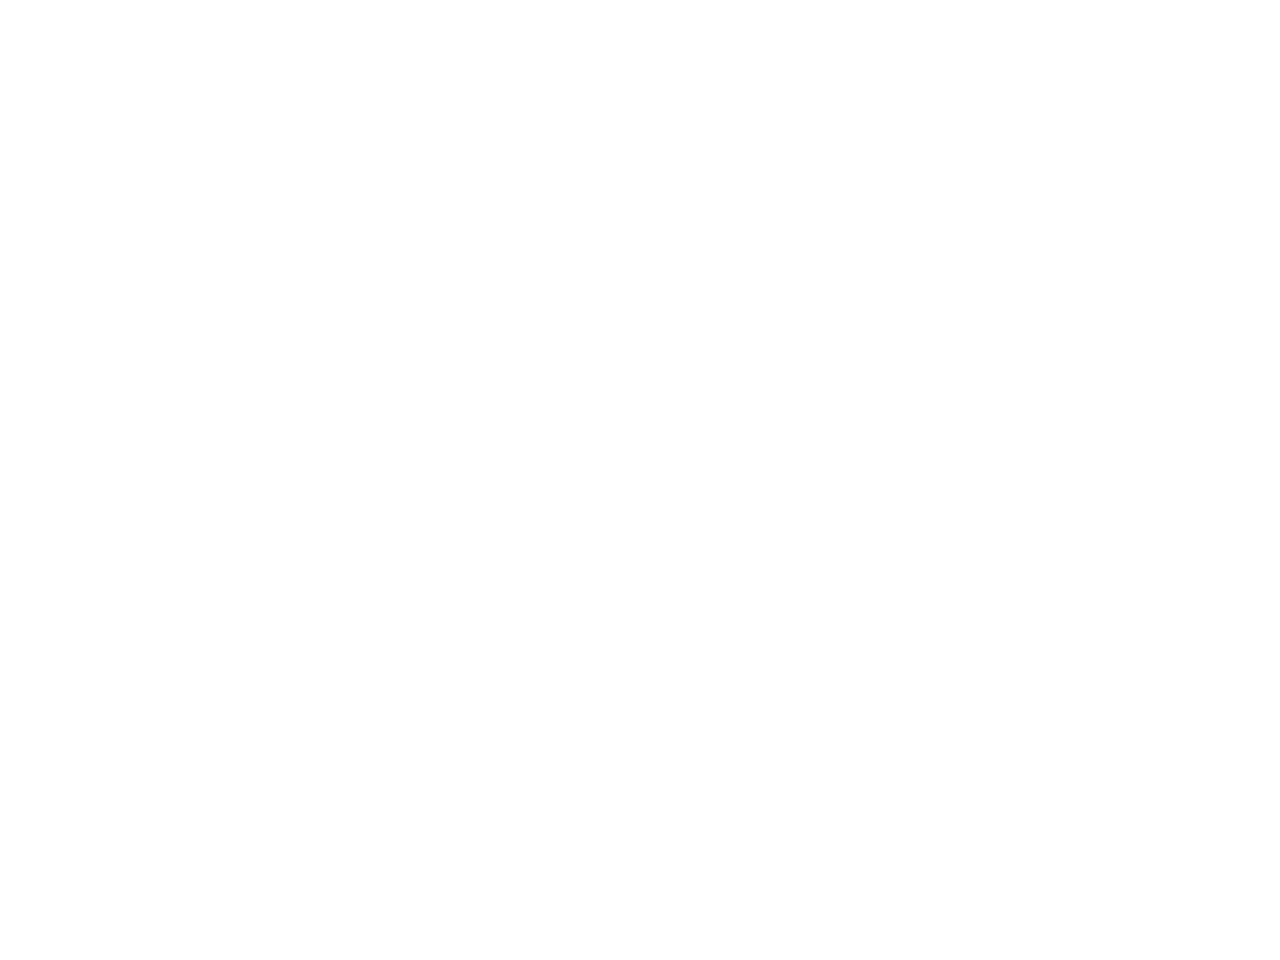

Traceback (most recent call last):
  File "<ipython-input-11-821eac033ff9>", line 6, in inner
    return fn(*args, **kwargs)
  File "<ipython-input-33-6b9062cebd56>", line 21, in predicted_goal_percent_comparison
    return cleaned[mispred_success | mispred_fail]
  File "/Users/chloele/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py", line 2135, in __getitem__
    return self._getitem_frame(key)
  File "/Users/chloele/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py", line 2218, in _getitem_frame
    raise ValueError('Must pass DataFrame with boolean values only')
ValueError: Must pass DataFrame with boolean values only



In [33]:
@cannot_crash
def predicted_goal_percent_comparison():

    clf = LinearSVC()
    clf.fit(all_features, Y)
    pred = clf.predict(all_features)

    plt.figure()

    pred_success = cleaned[pred == 1]
    pred_failures = cleaned[pred == 0]
    goal_percent_comparison(pred_success, pred_failures)
    plt.legend(['predicted successes', 'predicted failures'])

    mispred_success = cleaned[(pred == 0) & (cleaned.state == 'successful') ]
    mispred_fail = cleaned[(pred == 1) & (cleaned.state != 'successful') ]
    plt.figure()
    goal_percent_comparison(mispred_success, mispred_fail)
    plt.legend(['mispredicted successes', 'mispredicted failures'])
    
    return cleaned[mispred_success | mispred_fail]

predicted_goal_percent_comparison()

<IPython.core.display.Javascript object>


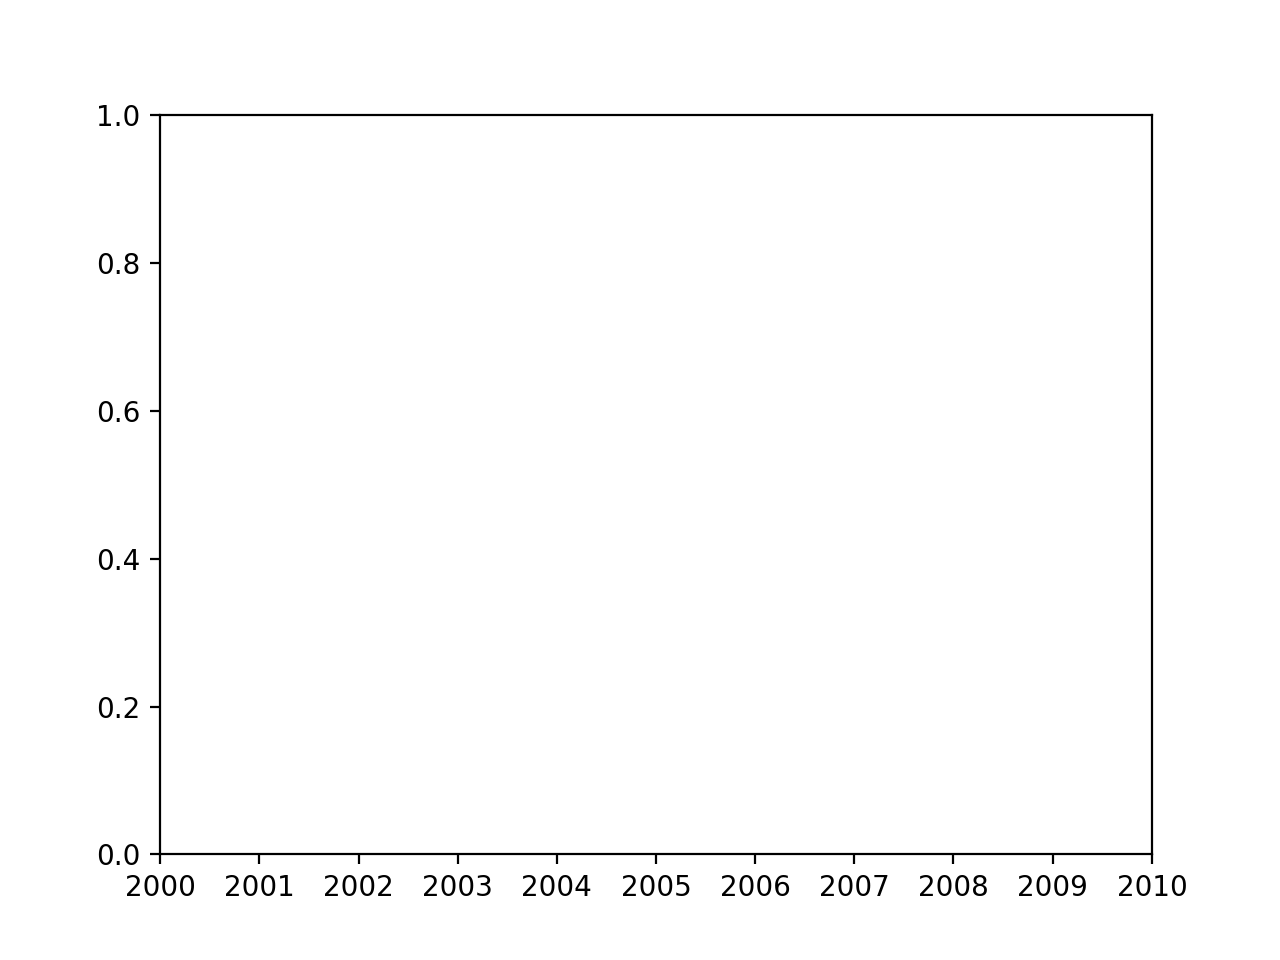

Traceback (most recent call last):
  File "<ipython-input-11-821eac033ff9>", line 6, in inner
    return fn(*args, **kwargs)
  File "<ipython-input-34-2d5379c16ca1>", line 4, in show_created_at_hist
    plt.hist(cleaned.created_at, 50)
  File "/Users/chloele/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py", line 3004, in hist
    stacked=stacked, normed=normed, data=data, **kwargs)
  File "/Users/chloele/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py", line 1710, in inner
    return func(ax, *args, **kwargs)
  File "/Users/chloele/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py", line 6193, in hist
    xmin = min(xmin, xi.min())
TypeError: invalid type promotion



In [34]:
%matplotlib notebook
@cannot_crash
def show_created_at_hist():
    plt.hist(cleaned.created_at, 50)
    plt.show()
    print(cleaned.created_at.min())
    print(cleaned.created_at.max())

show_created_at_hist()